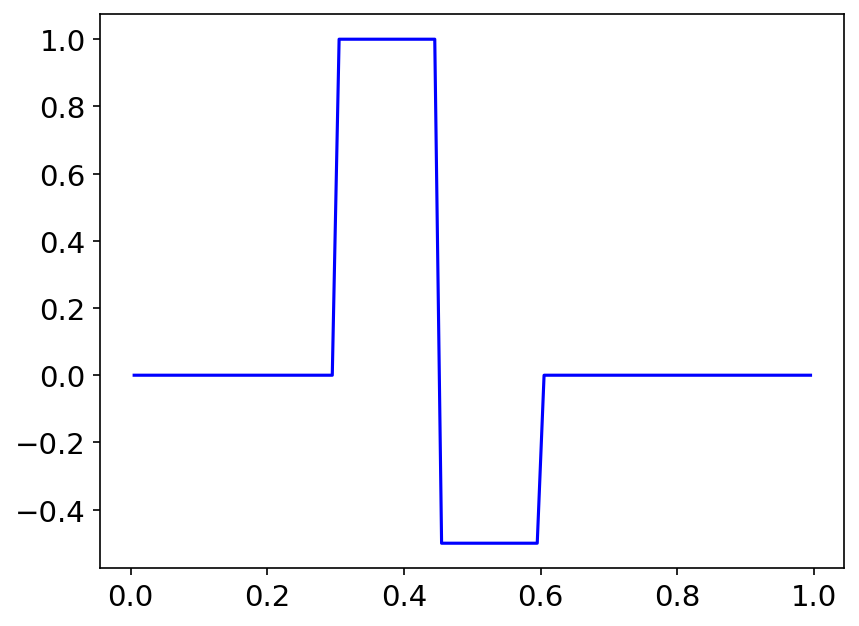

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from discretize import TensorMesh
from SimPEG import simulation, maps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 150

nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.cell_centers_x > 0.3] = 1.0
true_model[mesh.cell_centers_x > 0.45] = -0.5
true_model[mesh.cell_centers_x > 0.6] = 0

# Plotting the true model
plt.plot(mesh.cell_centers_x, true_model, "b-")

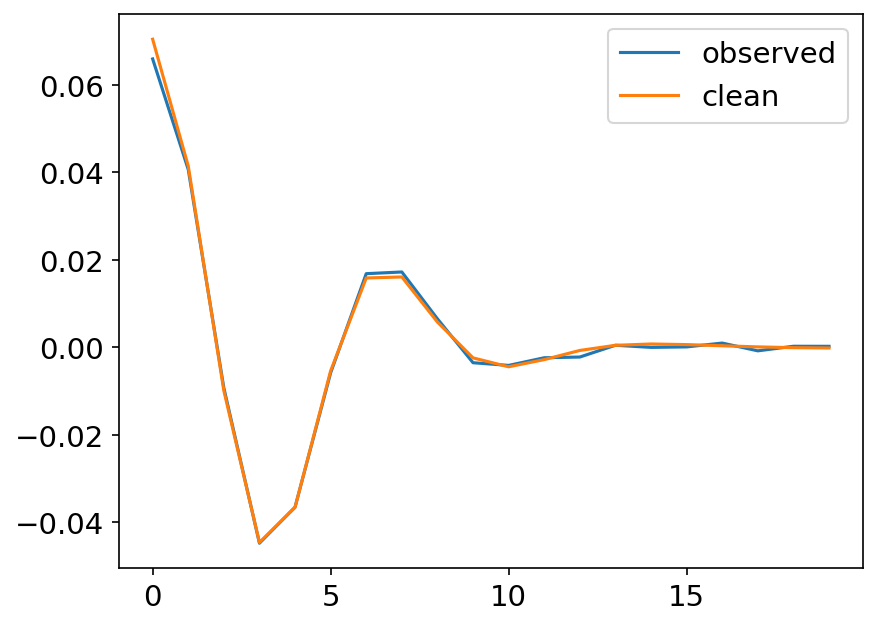

In [8]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial.
# The columns of the linear operator represents a set of decaying and oscillating functions.
sim = simulation.ExponentialSinusoidSimulation(
    model_map=maps.IdentityMap(), mesh=mesh, n_kernels=nData, p=-0.25, q=0.25, j0=1, jn=60
)
G = sim.G

# Standard deviation of Gaussian noise being added
data_std = 0.001
np.random.seed(3211)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, noise_floor=data_std, add_noise=True)

plt.plot(data_obj.dobs, label='observed')
plt.plot(data_obj.dclean, label='clean')
plt.legend()

3888.8673434670013 753.2177932338451
(100, 100) (100,)


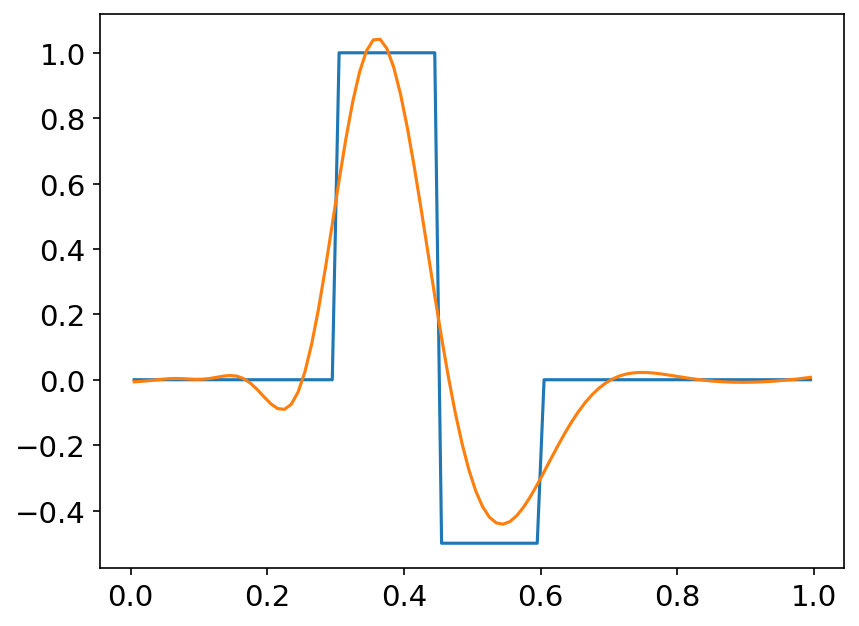

In [9]:
model_std = 0.4
Wd = np.diag(1/data_obj.standard_deviation)

A = G.T @ Wd.T @ Wd @ G + 1/model_std**2 * np.eye(G.shape[1])
b = G.T @ Wd.T @ Wd @  data_obj.dobs
print(np.linalg.norm(A), np.linalg.norm(b))
print(A.shape, b.shape)
m_max_post = np.linalg.solve(A, b)

del_d = Wd @ (G @ m_max_post - data_obj.dobs)
# print(del_d.T @ del_d)

plt.plot(mesh.cell_centers_x, true_model)
plt.plot(mesh.cell_centers_x, m_max_post)

plt.show()

# plt.hist((G.T @ Wd.T @ Wd @ data_obj.dobs).flatten())
# plt.show()
# plt.hist((1/model_std**2 * np.eye(G.shape[1])).flatten())

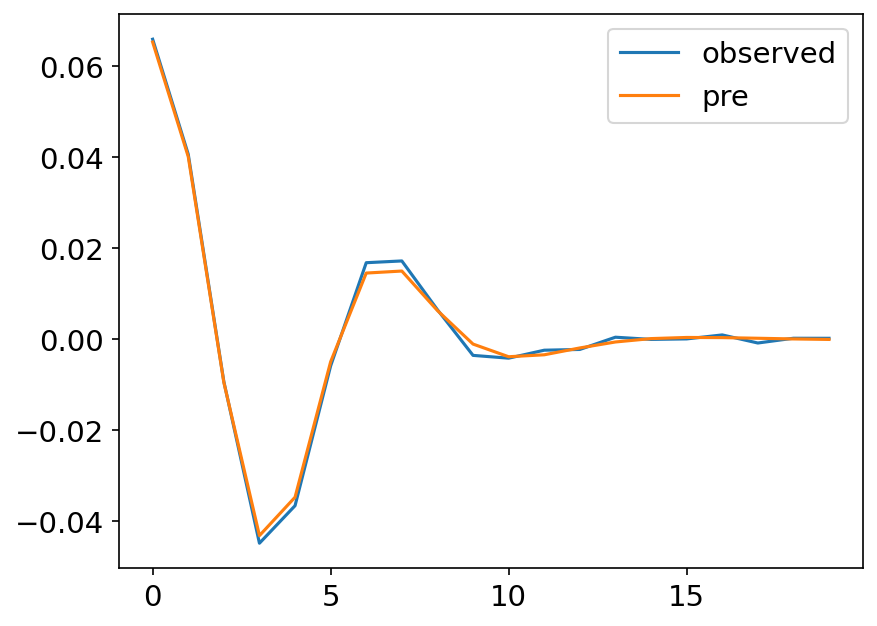

In [10]:
plt.plot(data_obj.dobs, label='observed')
plt.plot(G @ m_max_post, label='pre')
plt.legend()

## Create the perturbed data distrubution

(20, 20) (1, 20)


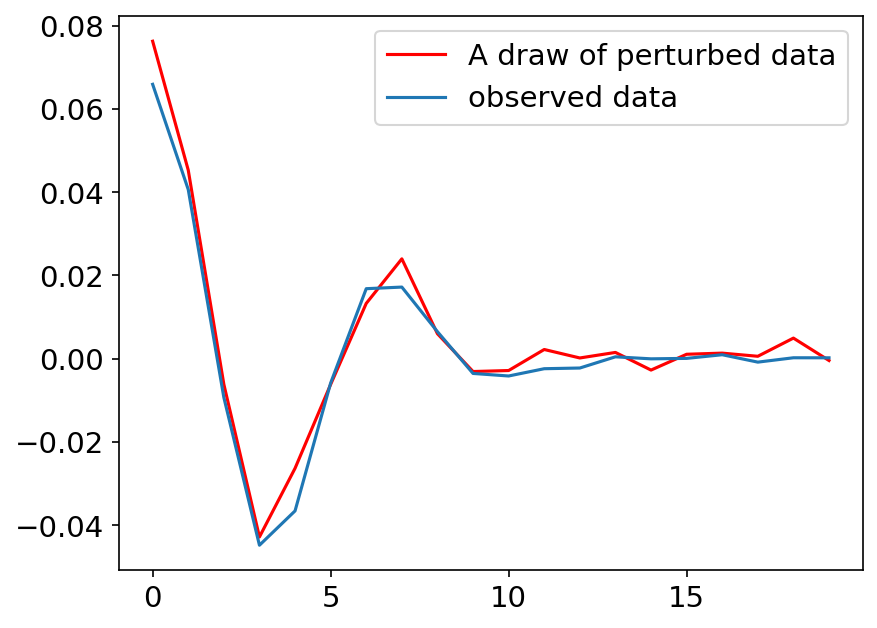

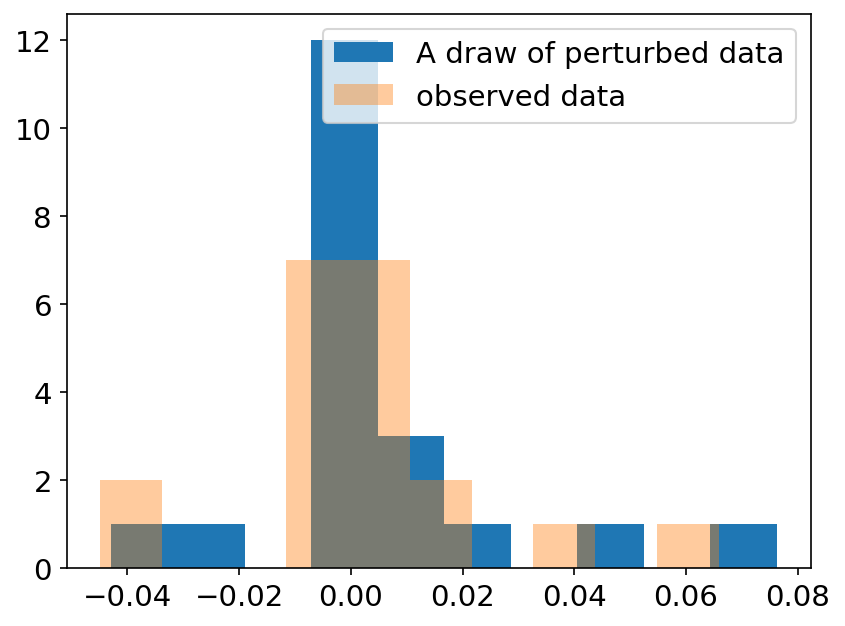

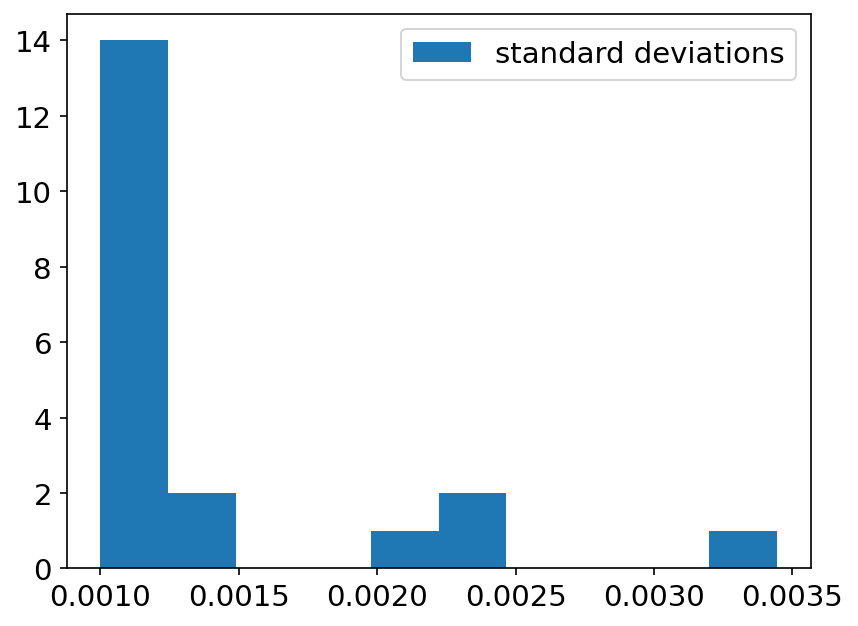

In [11]:
# Generate sample data
np.random.seed(0)

n_samples = 1000
n_components = 20
Wd = np.diag(data_obj.standard_deviation * 1e-2)

# Generate two Gaussian distribution
perturbed_data = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)

plt.plot(perturbed_data.T, 'r', label='A draw of perturbed data')
plt.plot(data_obj.dobs, label='observed data')
print(Wd.shape, perturbed_data.shape)
plt.legend()
plt.show()

plt.hist(perturbed_data.mean(axis=0), label='A draw of perturbed data')
plt.hist(data_obj.dobs, alpha=0.4, label='observed data')
plt.legend()
plt.show()

plt.hist(data_obj.standard_deviation, label='standard deviations')
plt.legend()
plt.show()

## create distrubution for perturbed model

(100, 100)
(1, 100) (100, 100)
(100, 1)


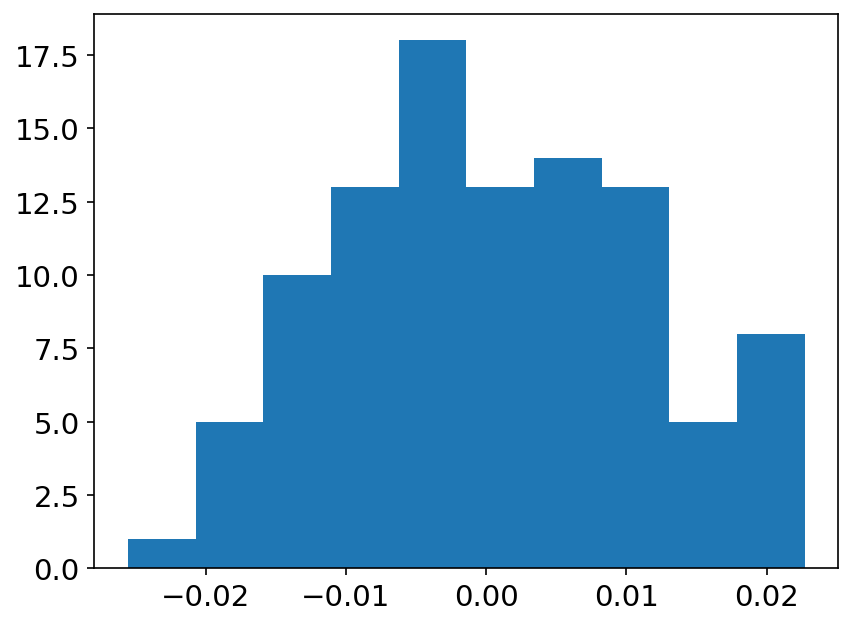

In [12]:
from scipy import linalg
mean = 0
mu = 1e4 #np.mean(data_obj.dobs)

identity_matrix = np.eye(100)
print(identity_matrix.shape)
zero_means = np.zeros(100)

s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)

# coefficient matrix
Wm = np.sqrt(mu) * np.eye(100)
print(s.shape, Wm.shape)
perturbed_model = np.linalg.solve(Wm, s.T)
print(perturbed_model.shape)
plt.hist(perturbed_model)
plt.show()


In [459]:
draws = []

Wm = linalg.inv(Wd)
mu = 4.0
Wd = np.diag(1/data_obj.standard_deviation)

A = G.T @ Wd.T @ Wd @ G + mu * np.eye(G.shape[1])
b = G.T @ Wd.T @ Wd @ perturbed_data.T + mu * np.eye(G.shape[1]) @ perturbed_model


# m_max_post = np.linalg.solve(A, b)
draws = m_max_post
# draws = np.hstack(draws)
# print(A.shape, b.shape, (G.T @ Wd.T @ Wd @ perturbed_data.T).shape )
# plt.plot(draws)
# plt.plot(data_obj.dobs, 'r')

# plt.hist((G.T @ Wd.T @ Wd @ perturbed_data.T).flatten())
# plt.show()
# plt.hist((mu * np.eye(G.shape[1]) @ perturbed_model).flatten())

# mu = 1e3
# A = G.T @ Wd.T @ Wd @ G
# b = G.T @ Wd.T @ Wd @ perturbed_data.T + mu / 2


# m_max_post_l1 = np.linalg.solve(A, b)
# draws = m_max_post
# # draws = np.hstack(draws)
# print((G.T @ Wd.T @ Wd @ G).shape, (mu * np.eye(G.shape[1])).shape)
# # plt.plot(draws)
# # plt.plot(data_obj.dobs, 'r')

# plt.hist((G.T @ Wd.T @ Wd @ perturbed_data.T).flatten())
# plt.show()
# plt.hist((mu * np.eye(G.shape[1]) @ perturbed_model).flatten())

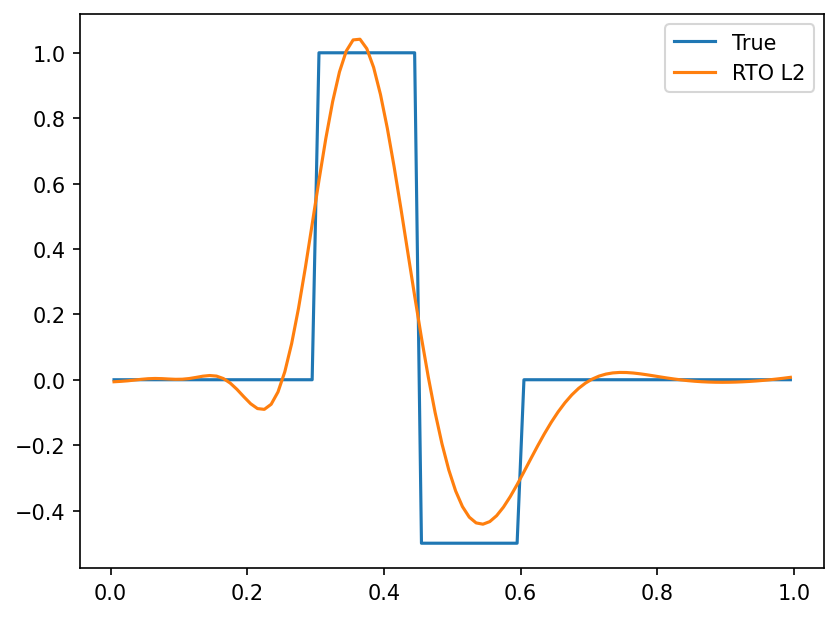

In [460]:
plt.plot(mesh.cell_centers_x, true_model, label='True')
plt.plot(mesh.cell_centers_x, draws, label='RTO L2')
# plt.plot(mesh.cell_centers_x, m_max_post_l1, label='RTOL1')
plt.legend()

## create function to perform rto-tko

In [13]:
def randomize_them_optimize(
        
        dobs:np.ndarray,
        n_samples:int=50,
        n_model_samples:int=100,
        n_components:int=20,
        mu_init:float=1e1,
        mu_perturb:float=1e4,
        standard_deviation:np.ndarray=None,
        TKO: bool=False,
        upper: float=np.inf,
        lower: float=-np.inf,
        
    ) -> np.ndarray:

    # Generate sample data
    np.random.seed(0)

    # data covariace matrix to perturb data
    Wd = np.diag(standard_deviation)

    # model zero mean guassian distribution
    identity_matrix = np.eye(n_model_samples)
    zero_means = np.zeros(n_model_samples)

    draws = []
    draws_mu = []

    for ii in range(n_samples):
    
        # draw from perturbed data distribution
        perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)

        # draw from perturbed model distribution
        s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)

        # coefficient matrix
        Wm = np.sqrt(mu_perturb) * np.eye(n_model_samples)
        
        # solve linear equation for perturbed model
        perturbed_model = np.linalg.solve(Wm, s.T)

        # data covariance matrix
        Cd = np.diag(1 / standard_deviation)

        # solve for model
        A = G.T @ Cd.T @ Cd @ G + mu_init * np.eye(G.shape[1])
        b = G.T @ Cd.T @ Cd @ perturbed_data.T + mu_init * np.eye(G.shape[1]) @ perturbed_model
        m_max_post = np.linalg.solve(A, b)
        
        # sample from tradeoff parameter to find best regularization beta
        if TKO:
            perturbed_data2 = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)
            mu_new = tko(G, perturbed_data2, Cd, m_max_post, mu_init)

            if lower < mu_new < upper:
                print(f"using mu: {mu_new} {mu_init}")
                draws_mu.append(mu_new[0])

        draws.append(m_max_post)
        
    # if TKO was selected send back the tradeoff parameter distribution
    if TKO:
        
        return np.hstack(draws), np.hstack(draws_mu) 
    
    return np.hstack(draws)

def tko(for_mat, perturbed_data_2, Cd, rto_model, mu_ref):

    G = for_mat.copy()
    initial_x = 20

    # Example usage with the function f(x) = x^2 - 4x + 4
    def objective_func(mu):
        r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T
        return 0.5 * np.linalg.norm(r)

    def gradient_func(mu):
        A = rto_model.T @ G.T @ Cd.T @ Cd @ G @ rto_model
        B = rto_model.T @ G.T @ Cd.T @ perturbed_data_2.T
        return np.sqrt(mu_ref / mu) * A - B

    def gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x:float):
        x = initial_x

        for i in range(iterations):

            xprev = np.array([x]).copy()

            # get residual
            r = objective_func(x)

            # Calculate the gradient at the current point
            grad = gradient_func(x)

            Ag = G * grad
            alpha = (r*Ag).mean()/(Ag*Ag).mean()
            
            # Update x using the gradient and learning rate
            # update = learning_rate * grad
            # print(f"alpha: {alpha}")

            x -= learning_rate * alpha * grad

            value = objective_func(x)
            # print(f"r: {r}, f(x): {value}")
            # if r < value:
            #     x = xprev[0]
            #     x -= learning_rate * alpha * grad
                # return xprev[0]

            if np.isnan(value):
        
                return xprev[0]
            
            # if (value < 0):
        
            #     return xprev

            # Print the current iteration and the value of the objective function
            # print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
        
        return x.copy()

    learning_rate = 1e-3
    iterations = 50

    result = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)
    # print("Final result: x =", result, mu_ref)

    return result

    
    

In [14]:
rto_results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=1000,
        n_model_samples=100,
        n_components=20,
        mu_init=10,
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        
)

tko_results, mu_results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=100,
        n_model_samples=100,
        n_components=20,
        mu_init=40,
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        TKO=True
        
)
print(f" mean: {mu_results.mean()}")
rto_tko_results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=1000,
        n_model_samples=100,
        n_components=20,
        mu_init=mu_results.mean(),
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        
)

C:\Users\johnk\AppData\Local\Temp\ipykernel_3888\2016961555.py:76: RuntimeWarning: invalid value encountered in sqrt
  r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T


using mu: [[4.89459017]] 40
using mu: [[5.99712244]] 40
using mu: [[7.45758446]] 40
using mu: [[2.81515013]] 40
using mu: [[6.80618182]] 40
using mu: [[3.22412087]] 40
using mu: [[5.78999631]] 40
using mu: [[2.53464481]] 40
using mu: [[4.75485296]] 40
using mu: [[2.04852442]] 40
using mu: [[3.76769859]] 40
using mu: [[3.5988854]] 40
using mu: [[6.69235708]] 40
using mu: [[1.23512882]] 40
using mu: [[3.62135267]] 40
using mu: [[0.95846779]] 40
using mu: [[5.16112899]] 40
using mu: [[0.28237948]] 40
using mu: [[5.71508826]] 40
using mu: [[0.60415454]] 40
using mu: [[3.71737368]] 40
using mu: [[6.99318138]] 40
using mu: [[6.43821642]] 40
using mu: [[2.46703348]] 40
using mu: [[5.12089974]] 40
using mu: [[3.75134174]] 40
using mu: [[1.06451314]] 40
using mu: [[1.64591795]] 40
using mu: [[5.19226739]] 40
using mu: [[1.74634551]] 40
using mu: [[1.5191939]] 40
using mu: [[0.82212954]] 40
using mu: [[1.71516259]] 40
using mu: [[4.14683031]] 40
using mu: [[2.08220409]] 40
using mu: [[1.79808043

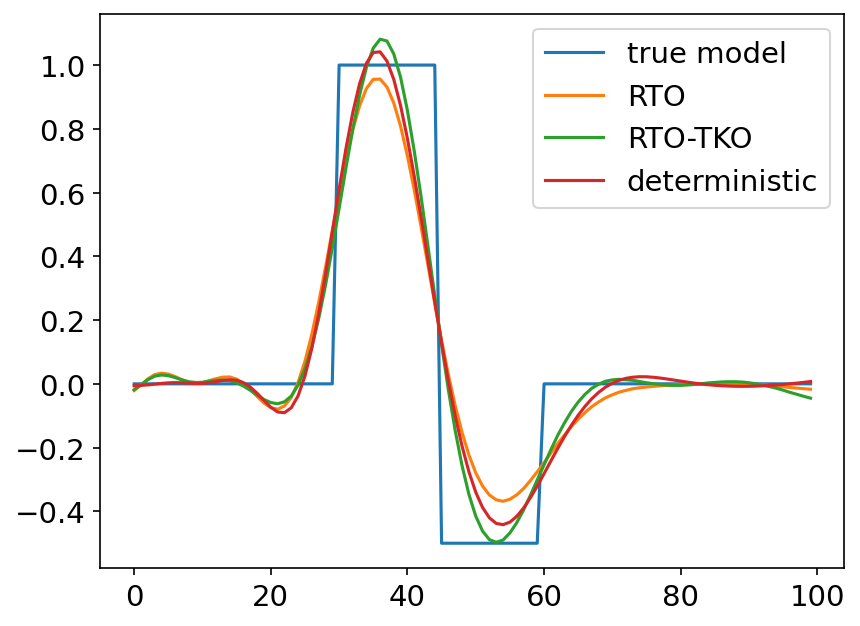

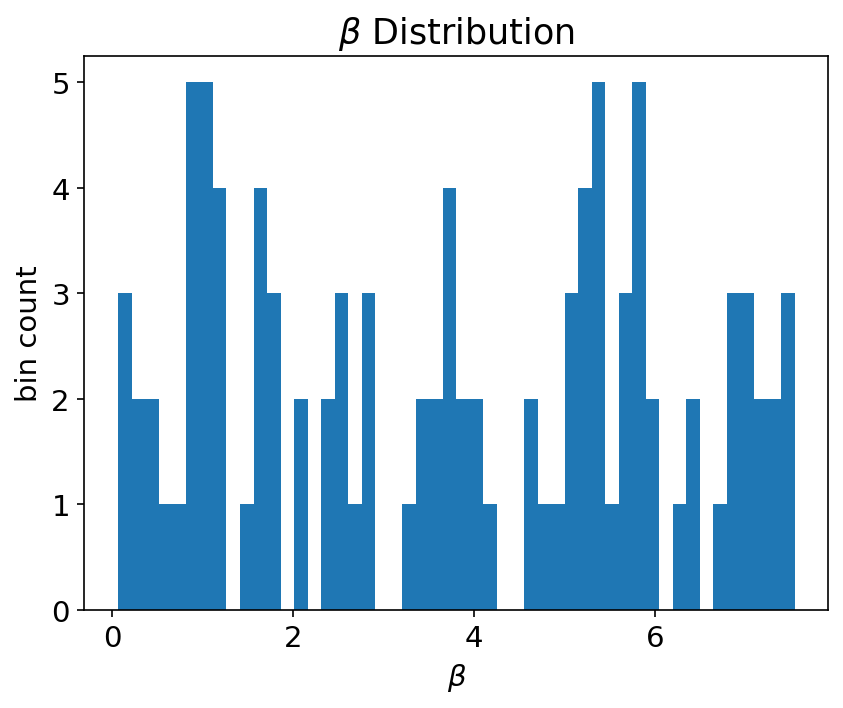

In [15]:
# print(results.shape)
plt.plot(true_model, label='true model')
plt.plot(rto_results.mean(axis=1), label='RTO')
plt.plot(rto_tko_results.mean(axis=1), label='RTO-TKO')
# plt.plot(rto_results[:, 1], label='RTO1')
# plt.plot(rto_results2.mean(axis=1), label='RTO2')
plt.plot(m_max_post, label='deterministic')
plt.legend()
plt.show()

plt.hist(mu_results.flatten(), 50)
plt.xlabel(r'$\beta$')
plt.ylabel('bin count')
plt.title(r'$\beta$ Distribution')
plt.show()

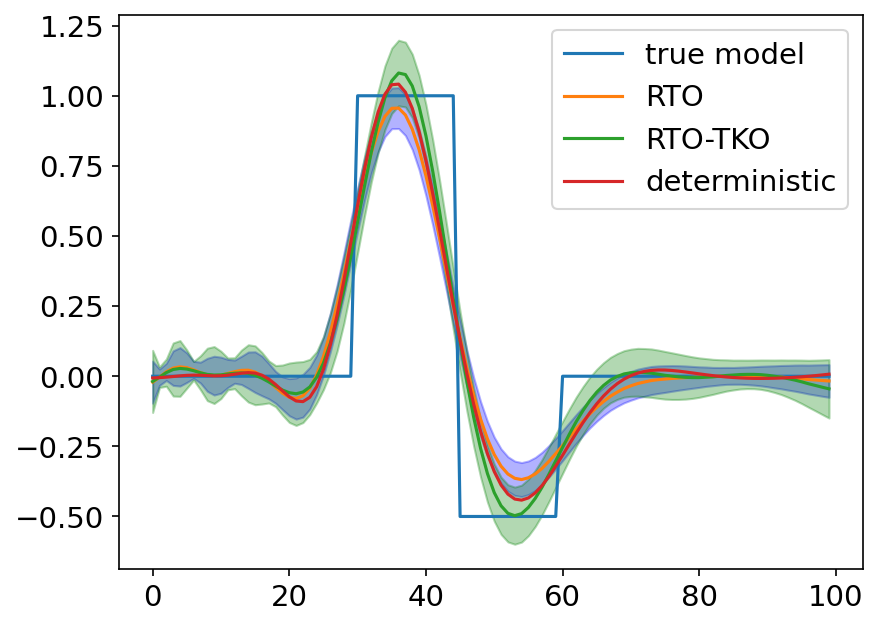

In [16]:
#some confidence interval
# print(results.shape)
y2 = rto_tko_results.mean(axis=1)
y = rto_results.mean(axis=1)
ci2 = []
for ii in range(100):
    ci2.append(1.96 * np.std(rto_tko_results[ii, :])/np.sqrt(rto_tko_results.shape[1]))

ci = []
for ii in range(100):
    ci.append(1.96 * np.std(rto_results[ii, :])/np.sqrt(rto_results.shape[1]))

plt.fill_between(np.arange(100), (y-ci), (y+ci), color='b', alpha=.3)
plt.fill_between(np.arange(100), (y2-ci2), (y2+ci2), color='g', alpha=.3)
plt.plot(true_model, label='true model')
plt.plot(rto_results.mean(axis=1), label='RTO')
plt.plot(rto_tko_results.mean(axis=1), label='RTO-TKO')
plt.plot(m_max_post, label='deterministic')
plt.legend()


17.952558562595993 37.04167022003964 16.789691205144642 323.3128691604149 362.589214595353


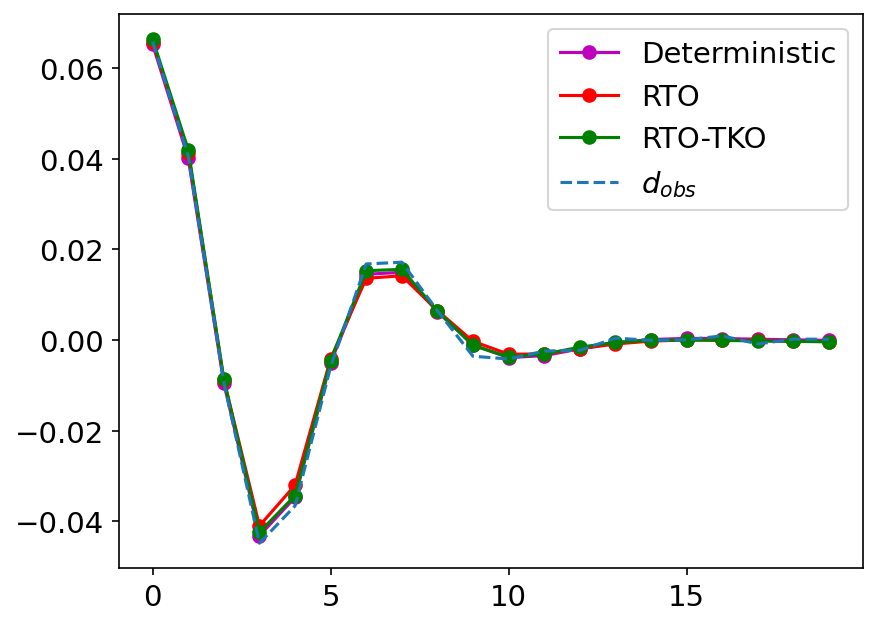

In [20]:
del_d = Wd @ (G @ rto_results.mean(axis=1) - data_obj.dobs)
del_d2 = Wd @ (G @ rto_tko_results.mean(axis=1) - data_obj.dobs)

Wm = np.sqrt(1e4) * np.eye(100)
del_m = Wm @ (rto_results.mean(axis=1) - np.zeros(100))
del_m2 = Wm @ (rto_tko_results.mean(axis=1) - np.zeros(100))
del_m3 = Wm @ (m_max_post - np.zeros(100))
print(np.sum(((G@m_max_post - data_obj.dobs)/ data_obj.standard_deviation)**2), np.sum(((G@rto_results.mean(axis=1) - data_obj.dobs)/ data_obj.standard_deviation)**2), np.sum(((G@rto_tko_results.mean(axis=1) - data_obj.dobs)/ data_obj.standard_deviation)**2), np.linalg.norm(del_m), np.linalg.norm(del_m2))

plt.plot(G @ m_max_post, 'o-m', label='Deterministic')
plt.plot(G @ rto_results.mean(axis=1), 'o-r', label='RTO')
plt.plot(G @ rto_tko_results.mean(axis=1), 'o-g', label='RTO-TKO')
plt.plot(data_obj.dobs, '--', label=r'$d_{obs}$')
plt.legend()

## TKO

In [166]:
1 / 0.00018

5555.555555555556

In [686]:
from scipy.sparse import spdiags
mu_ref = 1e1
mu_new = 1e3
mu_d = np.sqrt(mu_ref) / mu_ref
rto_model = results.mean(axis=1).T[:, None]
Wd = np.diag(data_obj.standard_deviation)
# perturbed data step 2
perturbed_data_2 = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)
# print(mu_d, Wd.shape, G.shape, rto_model.shape, perturbed_data_2.shape, (rto_model @ rto_model.T).shape)
# # A =  G.T @ Wd.T @ Wd @ G @ spdiags(rto_model[:, 0], 0, 100, 100)
# A = G.T @ Wd.T @ Wd @ G @ rto_model
# b =  G.T @ Wd.T @ Wd @ perturbed_data_2.T
# print(A.shape, b.shape)
# m_max_post = mu_d * np.linalg.solve(A, b)

# plt.hist(m_max_post)
# print(m_max_post.mean())
Cd = np.diag(1 / data_obj.standard_deviation)

# Example usage with the function f(x) = x^2 - 4x + 4
def objective_func(mu):
    r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T
    # print(0.5 * np.linalg.norm(r))
    return 0.5 * np.linalg.norm(r)

def gradient_func(mu):
    A = rto_model.T @ G.T @ Cd.T @ Cd @ G @ rto_model
    B = rto_model.T @ G.T @ Cd.T @ perturbed_data_2.T
    # print(G)
    # return np.sqrt(mu_ref / mu) * rto_model.T @ G.T @ Cd.T @ Cd @ G @ rto_model - rto_model.T @ G.T @ Cd.T @ perturbed_data_2.T
    return np.sqrt(mu_ref / mu) * A - B

def gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x):
    x = initial_x
    v = []
    v2 = []
    for i in range(iterations):

        xprev = np.array([x]).copy()

        # get residual
        r = objective_func(x)

        # Calculate the gradient at the current point
        grad = gradient_func(x)

        Ag = G * grad
        alpha = (r*Ag).mean()/(Ag*Ag).mean()
        
        # Update x using the gradient and learning rate
        # update = learning_rate * grad
        # print(f"update: {update} alpha: {alpha}")

        x -= learning_rate * alpha * grad

        value = objective_func(x)
        
        # if r<  value:
        #     return xprev[0]
        #     x = xprev[0]
        #     x += learning_rate * alpha * grad

        if np.isnan(value):
    
            return xprev[0]

        # plt.plot(v, v2, '.')
        
        # Print the current iteration and the value of the objective function
        print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
        v.append(x[0].copy())
        v2.append(value)

    plt.plot(v, v2, '-o')

    plt.show()
    
    return x

learning_rate = 1e-3
iterations = 50
initial_x = 30

result = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)
print("Final result: x =", result, mu_ref)

A = G.T @ Cd.T @ Cd @ G + result * np.eye(G.shape[1])
b = G.T @ Cd.T @ Cd @ perturbed_data.T + result * np.eye(G.shape[1]) @ perturbed_model
m_max_post_t = np.linalg.solve(A, b)
# plt.plot(m_max_post_t)
# pts = []
# for m_ in np.arange(0.1, 10, 0.1):
#     pts.append(objective_func(m_))
# plt.plot(np.arange(0.1, 10, 0.1), pts)
# plt.show()
# print(gradient_func(initial_x))

Iteration 1: x = [[25.01152696]], f(x) = 72.8054347839024
Iteration 2: x = [[20.02042979]], f(x) = 72.8857520406171
Iteration 3: x = [[15.02382656]], f(x) = 73.06244881771191
Iteration 4: x = [[10.01511007]], f(x) = 73.51604601170718
Iteration 5: x = [[4.97529772]], f(x) = 75.26593055867734
Final result: x = [[4.97529772]] 10.0


C:\Users\johnk\AppData\Local\Temp\ipykernel_10548\1885732839.py:22: RuntimeWarning: invalid value encountered in sqrt
  r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T


In [500]:
mu_ref / mu

2.5

# Set up a DC simulation

overwriting c:\Users\johnk\Documents\git\jresearch\baysian_inversion\dcr1d.tar.gz
   saved to: c:\Users\johnk\Documents\git\jresearch\baysian_inversion\dcr1d.tar.gz
Download completed!


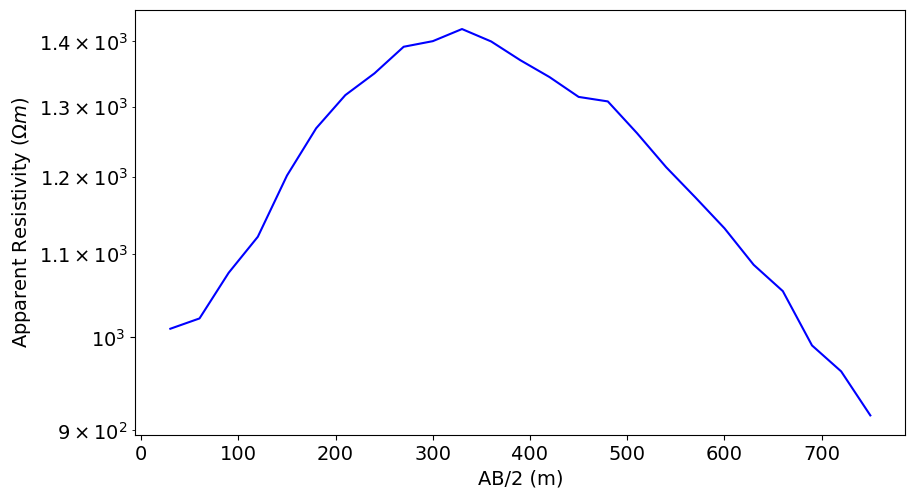

In [3]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model

mpl.rcParams.update({"font.size": 16})

# storage bucket where we have the data
data_source = "https://storage.googleapis.com/simpeg/doc-assets/dcr1d.tar.gz"

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
data_filename = dir_path + "app_res_1d_data.dobs"

# Load data
dobs = np.loadtxt(str(data_filename))

A_electrodes = dobs[:, 0:3]
B_electrodes = dobs[:, 3:6]
M_electrodes = dobs[:, 6:9]
N_electrodes = dobs[:, 9:12]
dobs = dobs[:, -1]

# Define survey
unique_tx, k = np.unique(np.c_[A_electrodes, B_electrodes], axis=0, return_index=True)
n_sources = len(k)
k = np.sort(k)
k = np.r_[k, len(k) + 1]

source_list = []
for ii in range(0, n_sources):
    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_locations = M_electrodes[k[ii] : k[ii + 1], :]
    N_locations = N_electrodes[k[ii] : k[ii + 1], :]
    receiver_list = [
        dc.receivers.Dipole(
            M_locations,
            N_locations,
            data_type="apparent_resistivity",
        )
    ]

    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = A_electrodes[k[ii], :]
    B_location = B_electrodes[k[ii], :]
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

# Plot apparent resistivities on sounding curve as a function of Wenner separation
# parameter.
electrode_separations = 0.5 * np.sqrt(
    np.sum((survey.locations_a - survey.locations_b) ** 2, axis=1)
)

fig = plt.figure(figsize=(11, 5))
mpl.rcParams.update({"font.size": 14})
ax1 = fig.add_axes([0.15, 0.1, 0.7, 0.85])
ax1.semilogy(electrode_separations, dobs, "b")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.show()

### Deterministic


  TensorMesh: 26 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     26          0.00        546.90      5.00     50.00    1.10



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.27e+01  2.16e+04  0.00e+00  2.16e+04    1.79e+03      0              
   1  1.27e+01  1.69e+03  9.94e+01  2.95e+03    1.88e+03      1              
   2  1.27e+01  1.17e+02  1.31e+02  1.78e+03 

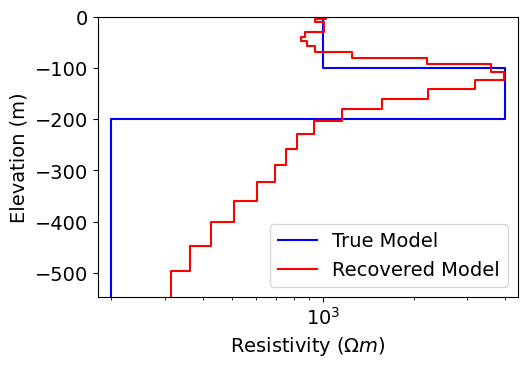

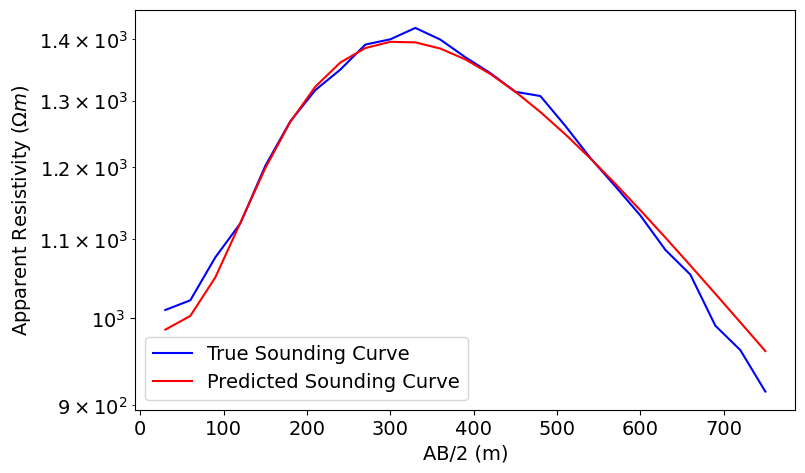

In [81]:
std = 0.02 * np.abs(dobs)

data_object = data.Data(survey, dobs=dobs.copy(), standard_deviation=std)

# Define layer thicknesses
layer_thicknesses = 5 * np.logspace(0, 1, 25)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

print(mesh)

# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))

# Define mapping from model to active cells.
model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh, alpha_s=1.0, alpha_x=1.0, reference_model=starting_model
)

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=20)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3.0)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model_deterministic = inv.run(starting_model)

# Define true model and layer thicknesses
true_model = np.r_[1e3, 4e3, 2e2]
true_layers = np.r_[100.0, 100.0]

# Plot true model and recovered model
fig = plt.figure(figsize=(6, 4))
x_min = np.min([np.min(model_map * recovered_model_deterministic), np.min(true_model)])
x_max = np.max([np.max(model_map * recovered_model_deterministic), np.max(true_model)])

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_model, ax=ax1, plot_elevation=True, color="b")
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model_deterministic,
    ax=ax1,
    plot_elevation=True,
    color="r",
)
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.legend(["True Model", "Recovered Model"])

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.semilogy(electrode_separations, dobs, "b")
ax1.semilogy(electrode_separations, inv_prob.dpred, "r")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.show()

### RTO

(25,) (25,)


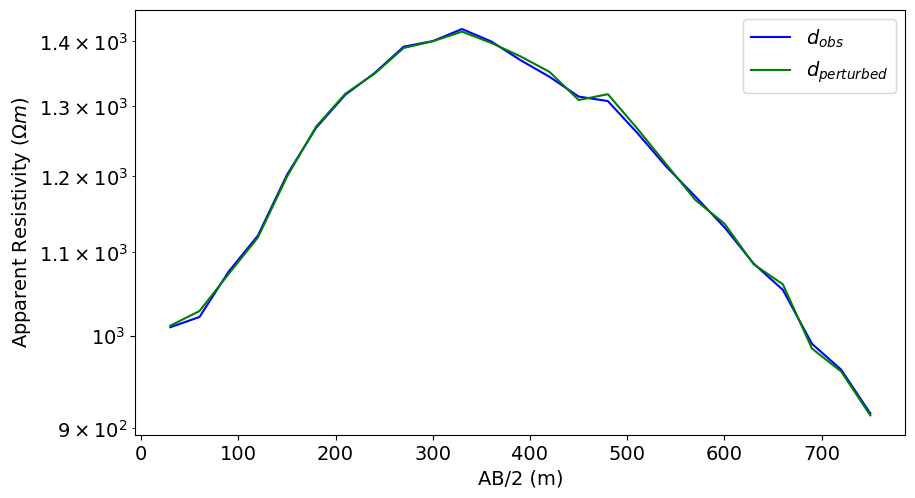

In [82]:
std = 0.02 * dobs
n_model_samples = 26
beta_perturb = 1e5

Wd = np.diag(std)

perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)[0, :]
print(dobs.shape, perturbed_data.shape)


fig = plt.figure(figsize=(11, 5))
mpl.rcParams.update({"font.size": 14})
ax1 = fig.add_axes([0.15, 0.1, 0.7, 0.85])
ax1.semilogy(electrode_separations, dobs, "b", label=r'$d_{obs}$')
ax1.semilogy(electrode_separations, perturbed_data, "g", label=r'$d_{perturbed}$')
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()

# data_object_rto = data.Data(survey, dobs=perturbed_data, standard_deviation=std)

# # Define layer thicknesses
# layer_thicknesses = 5 * np.logspace(0, 1, 25)

# # Define a mesh for plotting and regularization.
# mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

# print(mesh)

# # Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
# starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))

# # Define mapping from model to active cells.
# model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

# simulation = dc.simulation_1d.Simulation1DLayers(
#     survey=survey,
#     rhoMap=model_map,
#     thicknesses=layer_thicknesses,
# )




In [68]:
from distributed import Client
import dask

client = Client()

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\distributed\node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55480 instead
  warnings.warn(


In [104]:
# model zero mean guassian distribution
identity_matrix = np.eye(n_model_samples)
zero_means = np.zeros(n_model_samples)

starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))

beta_init = 1e-3
mu_init = 20
def tko(perturbed_data_2, Cd, rto_model, mu_ref):

    initial_x = 20
    data_object_tko = data.Data(survey, dobs=perturbed_data_2, standard_deviation=std)

    # create new misfit for data
    dmis_tko = data_misfit.L2DataMisfit(simulation=simulation, data=data_object_tko)

    reg_tko = regularization.Sparse(
        mesh, alpha_s=1, alpha_x=1e-2, reference_model=perturbed_model[:, 0]
    )

    # Example usage with the function f(x) = x^2 - 4x + 4
    def objective_func_tko(mu, x):
        # r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T
        r = dmis_tko(np.sqrt(mu_ref / mu) * x) + beta_init * reg_tko(np.sqrt(mu_ref / mu) * x)
        return 0.5 * np.linalg.norm(r)

    def gradient_func_tko(mu, x):

        return dmis_tko.deriv(np.sqrt(mu_ref / mu) * x) + beta_init * reg_tko.deriv(np.sqrt(mu_ref / mu)*x)

    def gradient_descent_tko(objective_func, gradient_func, learning_rate, iterations, model, initial_x:float):
        x = initial_x

        for i in range(iterations):

            xprev = np.array([x]).copy()

            # get residual
            r = objective_func(x, model)

            # Calculate the gradient at the current point
            grad = gradient_func(x, model)

            Ag = dmis_tko.simulation.dpred(grad)
            # alpha = (r*Ag).mean()/(Ag*Ag).mean()
            alpha = 1
            
            # Update x using the gradient and learning rate
            # update = learning_rate * grad
            # print(f"alpha: {alpha}")

            x -= learning_rate * alpha * grad

            value = objective_func(x, model)
            # print(f"r: {r}, f(x): {value}")
            # if r < value:
            #     x = xprev[0]
            #     x -= learning_rate * alpha * grad
                # return xprev[0]

            if np.isnan(value):
        
                return xprev[0]
            
            # if (value < 0):
        
            #     return xprev

            # Print the current iteration and the value of the objective function
            # print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
        
        return x.copy()

    learning_rate = 1e-3
    iterations = 50

    result = gradient_descent_tko(objective_func_tko, gradient_func_tko, learning_rate, iterations, rto_model, initial_x)
    # print("Final result: x =", result, mu_ref)

    return result

# Example usage with the function f(x) = x^2 - 4x + 4
def objective_func(x):
    # print(dmis(x).shape, beta_init, reg(x).shape)
    r = dmis_rto(x) + beta_init * reg_rto(x)
    return r

def gradient_func(x):
    return dmis_rto.deriv(x) + beta_init * reg_rto.deriv(x)

def gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x:float):
        x = initial_x
        previous_value = np.inf

        for i in range(iterations):

            xprev = np.array([x]).copy()

            # get residual
            r = dmis.simulation.dpred(x) - dobs

            # Calculate the gradient at the current point
            grad = gradient_func(x)

            Ag = dmis.simulation.Jvec(x, grad)
            alpha = (r*Ag).mean()/(Ag*Ag).mean()
            
            # Update x using the gradient and learning rate
            # update = learning_rate * grad
            # print(f"alpha: {alpha}")

            # x += learning_rate * alpha * grad

            x -= learning_rate * grad

            value = objective_func(x)

            if previous_value < value:
                 
                 break
                
            # print(f"f(x): {value}")
            # if r < value:
            #     x = xprev[0]
            #     x -= learning_rate * alpha * grad
                # return xprev[0]

            if np.isnan(value):
        
                return xprev[0]
            
            # if (value < 0):
        
            #     return xprev

            # Print the current iteration and the value of the objective function
            # print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
        
        return x.copy()

learning_rate = 1e-4
iterations = 100
initial_x = starting_model
result = []
ii = 0

# coefficient matrix
Wm = np.sqrt(beta_perturb) * np.eye(n_model_samples)

# solve linear equation for perturbed model
# draw from perturbed model distribution
# draws = []
draws_mu = []
TKO = True

while ii < 500:

    perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)[0, :]
    data_object = data.Data(survey, dobs=perturbed_data, standard_deviation=std)

    s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)
    perturbed_model = np.linalg.solve(Wm, s.T)

    # Define the data misfit. Here the data misfit is the L2 norm of the weighted
    # residual between the observed data and the data predicted for a given model.
    # Within the data misfit, the residual between predicted and observed data are
    # normalized by the data's standard deviation.
    dmis_rto = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    # reg_rto = regularization.WeightedLeastSquares(
    #     mesh, alpha_s=1e-2, alpha_x=1, reference_model=perturbed_model[:, 0]
    # )
    reg_rto = regularization.Sparse(
        mesh, alpha_s=1, alpha_x=1e-2, reference_model=perturbed_model[:, 0]
    )

    rto_model = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)

    # sample from tradeoff parameter to find best regularization beta
    if TKO:
        
        perturbed_data2 = np.random.multivariate_normal(dobs, Wd, size=1)[0, :]
        mu_new = tko(perturbed_data2, Wd, rto_model, mu_init)
        print(mu_new)
        if 1e-4 < mu_new < 10:
            print(f"using mu: {mu_new} {mu_init}")
            draws_mu.append(mu_new[0])
        print(mu_new)
        beta_init = mu_new[0]

        # draws.append(m_max_post)
        result.append(gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x))

    else:

        result.append(rto_model)

    ii += 1

# print(np.exp(result))

# while ii < 500:

#     perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)[0, :]
#     data_object = data.Data(survey, dobs=perturbed_data, standard_deviation=std)

#     s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)
#     perturbed_model = np.linalg.solve(Wm, s.T)

#     # Define the data misfit. Here the data misfit is the L2 norm of the weighted
#     # residual between the observed data and the data predicted for a given model.
#     # Within the data misfit, the residual between predicted and observed data are
#     # normalized by the data's standard deviation.
#     dmis_rto = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

#     # Define the regularization (model objective function)
#     reg_rto = regularization.WeightedLeastSquares(
#         mesh, alpha_s=1e-2, alpha_x=1, reference_model=perturbed_model[:, 0]
#     )

#     request = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)

#     ii += 1
#     if request is not None:
        
#         futures += [request]

#     else:

#         # processed time series hdf5 already exists, yay
#         pass

# dps = client.compute(futures)

# dps_gather = client.gather(dps)


c:\users\johnk\documents\git\simpegmp\SimPEG\electromagnetics\static\resistivity\simulation_1d.py:49: RuntimeWarning: divide by zero encountered in divide
  t = (t + rho[i] * tanh[i]) / (1.0 + t * tanh[i] / rho[i])


[43.42047344 37.50119067 38.2331979  38.7451592  39.35001101 40.04151331
 40.77181774 41.49770522 42.17557639 42.75801437 43.19418366 43.4327675
 43.42670641 43.13890029 42.54813458 41.65391004 40.47935129 39.07109806
 37.49605932 35.83589625 34.18053615 32.62416368 31.26744351 30.23461397
 29.7238442  46.29255527]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [70]:
result = dps_gather

### HMC

In [87]:
data_object_hmc = data.Data(survey, dobs=dobs.copy(), standard_deviation=std)

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis_hmc = data_misfit.L2DataMisfit(simulation=simulation, data=data_object_hmc)

# Define the regularization (model objective function)
reg_hmc = regularization.Sparse(
    mesh, alpha_s=1, alpha_x=1,
)

# Example usage with the function f(x) = x^2 - 4x + 4
def objective_func(x):
    # print(dmis(x).shape, beta_init, reg(x).shape)
    r = dmis_hmc(x) + beta_init * reg_hmc(x)
    return r

def gradient_func(x):
    return dmis_hmc.deriv(x) + beta_init * reg_hmc.deriv(x)

from scipy import stats

def hmc(neg_log_func, d_neg_log_func, n_samples, x0, n_leap_frog=4 ,step_size=0.25, p_std=1):

    samples = [x0, ]
    M = np.diag(p_std**2 * np.ones_like(x0))
    momentum_dist = stats.multivariate_normal(mean=np.zeros_like(x0), cov=M)
    M_inv = 1/p_std**2 * np.ones_like(x0)
    
    n_accept = 0 
    deriv = d_neg_log_func(samples[0])
    x0_nlp = neg_log_func(samples[0])
    for i in range(n_samples):
        x0 = samples[-1]
        x1 = x0.copy()
        
        p0 = momentum_dist.rvs()
        p1 = p0.copy()

        # leapfrog integration begin
        deriv = d_neg_log_func(x1)
        for s in range(n_leap_frog):
            p1 -= step_size * deriv/2
            x1 += step_size * M_inv * p1
            deriv = d_neg_log_func(x1)
            p1 -= step_size * deriv/2
        # leapfrog integration end
        p1 *= -1
        # reverse momentum at the final location for reversibility
        # In this case the momentum distribution is symmetric, so it doesn't matter...

        #metropolis acceptance
        x1_nlp = neg_log_func(x1)
        
        p0_nlp = -momentum_dist.logpdf(p0)
        p1_nlp = -momentum_dist.logpdf(p1)
        
        # Account for negatives AND log(probabiltiies)...
        target = x0_nlp - x1_nlp # f(x1)/f(x0)
        adjustment = p0_nlp - p1_nlp # g(p1)/g(p0)
        acceptance = target + adjustment # rf * rg
        
        if np.log(np.random.random()) <= acceptance:
            samples.append(x1)
            x0_nlp = x1_nlp
            n_accept += 1
        else:
            samples.append(x0)

    return np.array(samples), n_accept


samples, n_accept = hmc(
    objective_func, gradient_func, n_samples=1000, x0=starting_model, n_leap_frog=5 ,step_size=0.1
)
print(n_accept)

c:\users\johnk\documents\git\simpegmp\SimPEG\electromagnetics\static\resistivity\simulation_1d.py:49: RuntimeWarning: invalid value encountered in divide
  t = (t + rho[i] * tanh[i]) / (1.0 + t * tanh[i] / rho[i])
c:\users\johnk\documents\git\simpegmp\SimPEG\electromagnetics\static\resistivity\simulation_1d.py:49: RuntimeWarning: divide by zero encountered in divide
  t = (t + rho[i] * tanh[i]) / (1.0 + t * tanh[i] / rho[i])
c:\users\johnk\documents\git\simpegmp\SimPEG\maps.py:1880: RuntimeWarning: overflow encountered in exp
  return np.exp(mkvc(m))


0


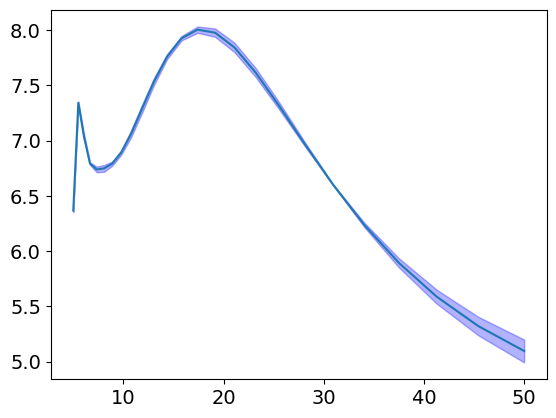

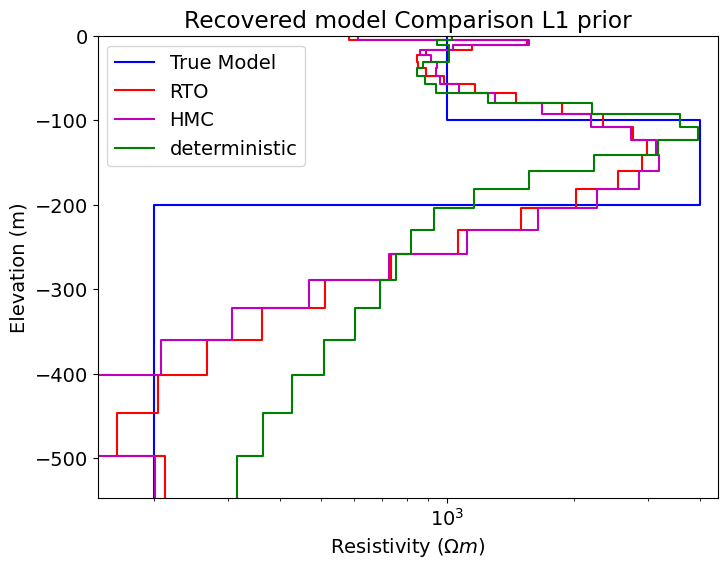

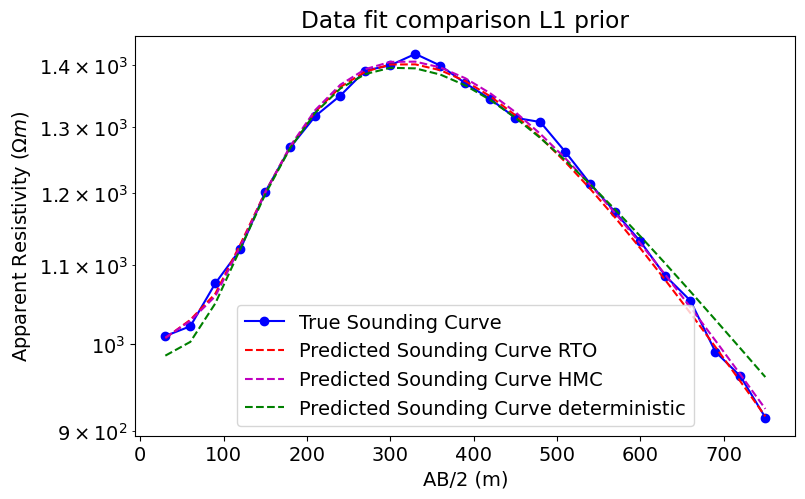

2023-08-11 22:44:25,928 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:53921', name: 3, status: running, memory: 0, processing: 0>
2023-08-11 22:44:26,134 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:54861', name: 0, status: running, memory: 51, processing: 0>
2023-08-11 22:44:26,137 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:53921'.
2023-08-11 22:44:26,517 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:54861'.
2023-08-11 22:44:40,487 - distributed.nanny - WARNING - Restarting worker

Traceback (most recent call last):
  File "c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\distributed\utils.py", line 778, in wrapper
    return await func(*args, **kwargs)
  File "c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\dist

In [ ]:
# print(np.hstack(result).shape)
recovered_model = np.vstack(result).mean(axis=0)
recovered_model_hmc = np.vstack(samples).mean(axis=0)
#  Define true model and layer thicknesses
# true_model = np.r_[1e3, 4e3, 2e2]
# true_layers = np.r_[50.0, 50.0]

# Plot true model and recovered model
x_min = np.min([np.min(model_map * recovered_model), np.min(true_model)])
x_max = np.max([np.max(model_map * recovered_model), np.max(true_model)])

rto_results = np.vstack(result)
y = rto_results.mean(axis=0)
ci = []
for ii in range(rto_results.shape[1]):
    ci.append(1.96 * np.std(rto_results[:, ii])/np.sqrt(rto_results.shape[1]))

plt.fill_between(layer_thicknesses, (y-ci)[:-1], (y+ci)[:-1], color='b', alpha=.3)
plt.plot(layer_thicknesses, recovered_model[:-1])
plt.show()

# fig = plt.figure(figsize=(8, 6))
fig, ax1 = plt.subplots(1, figsize=(8, 6))
plot_1d_layer_model(true_layers, true_model, ax=ax1, plot_elevation=True, color="b")
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model,
    ax=ax1,
    plot_elevation=True,
    color="r",
)
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model_hmc,
    ax=ax1,
    plot_elevation=True,
    color="m",
)
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model_deterministic,
    ax=ax1,
    plot_elevation=True,
    color="g",
)


ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.legend(["True Model", "RTO", "HMC", "deterministic"])
ax1.set_title("Recovered model Comparison L1 prior")
# plt.legend()
plt.show()

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.semilogy(electrode_separations, dobs, "-ob")
ax1.semilogy(electrode_separations, dmis_rto.simulation.dpred(np.vstack(result).mean(axis=0)), "--r")
ax1.semilogy(electrode_separations, dmis_hmc.simulation.dpred(np.vstack(hmc_results).mean(axis=0)), "--m")
ax1.semilogy(electrode_separations, inv_prob.dpred, "--g")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.set_title("Data fit comparison L1 prior")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve RTO", "Predicted Sounding Curve HMC", "Predicted Sounding Curve deterministic"])
plt.show()

$$
\mathbf{J}^{\top} \mathbf{W}^{\top} \mathbf{W}
            (\mathbf{d} - \mathbf{d}^{obs})

$$

$$
r(m) = \frac{1}{2}(\mathbf{m} - \mathbf{m_ref})^\top \mathbf{V}^T
            \mathbf{W}^T
        \mathbf{W} \mathbf{V} (\mathbf{m} - \mathbf{m_{ref}})
$$

### Latin hyper cube

Latin Hypercube Samples:
[[-0.23565748  4.90520146 -3.33694529]
 [-2.90106426  2.99735072 -3.33271821]
 [ 0.25326772  4.74612389 -4.04677509]
 [ 0.55784391  6.45272324 -2.91056833]
 [-0.37678766  6.08478082 -3.0771727 ]
 [-0.62578372  3.38351209 -2.91829546]
 [ 0.42908691  7.52513787 -3.64115211]
 [ 0.07827071  5.92107061 -2.8688338 ]
 [-0.61193383  5.66735661 -3.11001052]
 [ 0.83540431  6.95866023 -3.7068067 ]
 [ 0.89479694  2.21981018 -1.95971894]
 [-1.13025526  3.39266889 -3.18252241]
 [ 0.39738546  2.29223251 -3.29903161]
 [ 0.20056856  4.49083094 -2.72049356]
 [ 1.03032038  4.01100824 -3.25963847]
 [-0.8688542   5.08475299 -3.04225611]
 [-0.9059611   3.84266694 -2.03554808]
 [-1.83305961  3.68888076 -3.52540731]
 [ 0.1538161   6.33009772 -2.87704075]
 [-0.78759139  7.74765647 -2.71828398]
 [ 0.7012127   9.01756639 -3.39439066]
 [ 0.6014011   4.11910354 -2.81674831]
 [ 0.35547724  5.61372197 -2.9044691 ]
 [-1.28061757  3.51052654 -2.90170584]
 [ 0.98805592  4.82570086 -3.10924767]


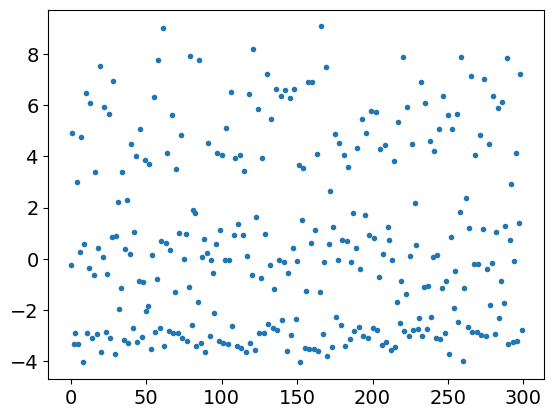

In [5]:
import numpy as np
from scipy.stats import norm

def latin_hypercube_sample(n_samples, n_variables, dist_params):
    # Generate LHS points
    lhs_points = np.random.rand(n_samples, n_variables)
    
    # Shuffle the columns of the LHS points matrix
    for i in range(n_variables):
        lhs_points[:, i] = np.random.permutation(lhs_points[:, i])
    
    # Transform LHS points using the desired distribution
    samples = np.zeros_like(lhs_points)
    for i in range(n_variables):
        samples[:, i] = norm.ppf(lhs_points[:, i], loc=dist_params[i][0], scale=dist_params[i][1])
    
    return samples

# Number of samples and variables
n_samples = 100
n_variables = 3

# Parameters for the Gaussian distribution for each variable: (mean, std_deviation)
dist_params = [(0, 1), (5, 2), (-3, 0.5)]

# Generate Latin Hypercube Samples with specified distribution
lhs_samples = latin_hypercube_sample(n_samples, n_variables, dist_params)

print("Latin Hypercube Samples:")
print(lhs_samples)

plt.plot(lhs_samples.flatten(), '.')
plt.show()


In [ ]:
class bayesianInverse:

    def __init__(
            
            self, 
            data_misfit=None,
            model_misfit=None,
            standard_deviation=0.05,
            n_samples:int=50,
            n_model_samples:int=100,
            n_components:int=20,
            beta_init:float=1e1,
            beta_perturb:float=1e4,
              
    ):

        self.data_misfit  = data_misfit
        self.model_misfit = model_misfit
        self.standard_deviation = standard_deviation
        self.n_model_samples = n_model_samples
        self.beta_perturb = beta_perturb
        self.n_components = n_components
        self.beta_init = beta_init
        
        # generate the perturbed distributions
        # Generate sample data
        np.random.seed(0)

        # data covariace matrix to perturb data
        self.Wd = np.diag(standard_deviation)

    # Example usage with the function f(x) = x^2 - 4x + 4
    def objective_func(self, x):
        r =  self.data_misfit(x) + self.beta_init * self.reg(x)
        return r

    def gradient_func(self, x):
        return self.data_misfit.deriv(x) + self.reg.deriv(x)

    def run(self):

        # model zero mean guassian distribution
        identity_matrix = np.eye(self.n_model_samples)
        zero_means = np.zeros(self.n_model_samples)

        draws = []
        draws_mu = []

        for ii in range(n_samples):
        
            # draw from perturbed data distribution
            perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)

            # draw from perturbed model distribution
            s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)

            # coefficient matrix
            Wm = np.sqrt(self.mu_perturb) * np.eye(self.n_model_samples)
            
            # solve linear equation for perturbed model
            perturbed_model = np.linalg.solve(Wm, s.T)

            # data covariance matrix
            Cd = np.diag(1 / self.standard_deviation)

    
    def gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x:float):
        x = initial_x

        for i in range(iterations):

            xprev = np.array([x]).copy()

            # get residual
            r = objective_func(x)

            # Calculate the gradient at the current point
            grad = gradient_func(x)

            Ag = G * grad
            alpha = (r*Ag).mean()/(Ag*Ag).mean()
            
            # Update x using the gradient and learning rate
            # update = learning_rate * grad
            # print(f"alpha: {alpha}")

            x -= learning_rate * alpha * grad

            value = objective_func(x)
            # print(f"r: {r}, f(x): {value}")
            # if r < value:
            #     x = xprev[0]
            #     x -= learning_rate * alpha * grad
                # return xprev[0]

            if np.isnan(value):
        
                return xprev[0]
            
            # if (value < 0):
        
            #     return xprev

            # Print the current iteration and the value of the objective function
            # print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
        
        return x.copy()

    learning_rate = 1e-3
    iterations = 50